<h1> COVIDForecasting </h1>
<h3> Simran Soin -- June 2020</h3><br>
<i> Data and idea based on the <a href="https://www.kaggle.com/c/covid19-global-forecasting-week-5/data?select=submission.csv">Kaggle COVID19 Global Forecasting Challenge</a></i>


<h2> Uploaded the train/test csv files into an S3 Bucket on AWS and accessed both csv files by importing them directly into Pandas DataFrames </h2>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

test_data = pd.read_csv("https://covid-training-data.s3.us-east-2.amazonaws.com/test.csv")
test_data.head()

,ForecastId,County,Province_State,Country_Region,Population,Weight,Date,Target
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-04-27,ConfirmedCases
1,2,NaN,NaN,Afghanistan,27657145,0.583587,2020-04-27,Fatalities
2,3,NaN,NaN,Afghanistan,27657145,0.058359,2020-04-28,ConfirmedCases
3,4,NaN,NaN,Afghanistan,27657145,0.583587,2020-04-28,Fatalities
4,5,NaN,NaN,Afghanistan,27657145,0.058359,2020-04-29,ConfirmedCases


In [2]:
train_data = pd.read_csv("https://covid-training-data.s3.us-east-2.amazonaws.com/train.csv")
train_data.head()

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0.0
1,2,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0.0
2,3,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0.0
3,4,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0.0
4,5,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0.0


<h2> Split Training Data into Two DataFrames: Confirmed Cases and Fatalities </h2>

In [3]:
train_confirmed = train_data[train_data['Target']=="ConfirmedCases"]
train_confirmed.head()

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0.0
2,3,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0.0
4,5,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0.0
6,7,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-26,ConfirmedCases,0.0
8,9,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-27,ConfirmedCases,0.0


In [4]:
train_fatalities = train_data[train_data['Target']=='Fatalities']
train_fatalities.head()

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
1,2,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0.0
3,4,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0.0
5,6,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-25,Fatalities,0.0
7,8,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-26,Fatalities,0.0
9,10,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-27,Fatalities,0.0


<h2> Visualize the data from Afghanistan for all available dates to get a better idea of trends </h2>

CONFIRMED CASES DATA:


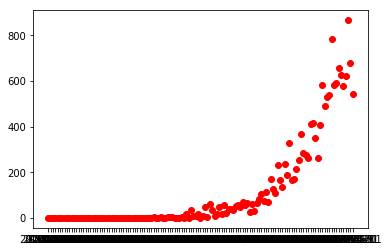

In [5]:
afghanistan_confirmed_data = train_confirmed[train_confirmed['Country_Region']=='Afghanistan']
print("CONFIRMED CASES DATA:")
plt.scatter(afghanistan_confirmed_data['Date'], afghanistan_confirmed_data['TargetValue'], color='red')

FATALITIES DATA:


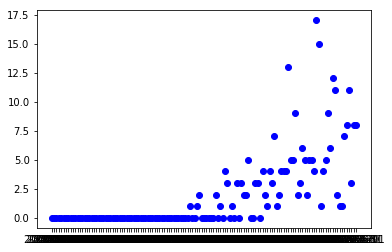

In [6]:
afghanistan_fatality_data = train_fatalities[train_fatalities['Country_Region']=='Afghanistan']
print("FATALITIES DATA:")
plt.scatter(afghanistan_fatality_data['Date'], afghanistan_fatality_data['TargetValue'], color='blue')